In [718]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import warnings
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")

In [719]:
ticker = "SHARDACROP"
# ticker='TCS.NS'
sp500 = yf.Ticker(ticker)
sp500 = sp500.history(period="max")  # You can change the period as needed


Failed to get ticker 'SHARDACROP' reason: HTTPSConnectionPool(host='query2.finance.yahoo.com', port=443): Read timed out. (read timeout=10)
$SHARDACROP: possibly delisted; No timezone found


In [720]:

sp500.index

Index([], dtype='object', name='Date')

In [721]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<Axes: xlabel='Date'>

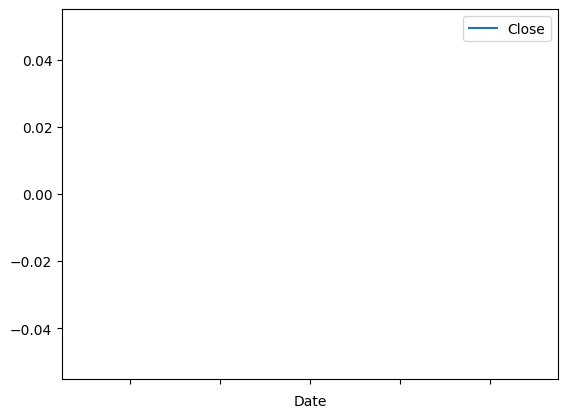

In [722]:
sp500.plot.line(y='Close', use_index=True)

In [723]:
sp500=sp500.drop(columns=['Dividends', 'Stock Splits'])

KeyError: "['Dividends', 'Stock Splits'] not found in axis"

In [ ]:
sp500.columns

### We took the shift Column and we took the price back 1 day.

In [ ]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)

In [ ]:
sp500

In [ ]:
sp500['Target'] = (sp500["Tomorrow"] > sp500['Close']).astype(int)

In [ ]:
sp500

In [ ]:
sp500 = sp500.loc['1990-01-01':].copy()
sp500 = sp500.loc[:'2022-05-18'].copy()

In [ ]:
sp500

## Random forest Classifier

In [ ]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

In [ ]:
sp500.columns

In [ ]:
features=['Close','Volume','Open','High','Low']

# Extract features and target for training
X_train = train[features]
y_train = train['Target']

# Extract features and target for testing
X_test = test[features]
y_test = test['Target']

In [ ]:


model.fit(X_train,y_train)

### Predict Data

In [ ]:
from sklearn.metrics import precision_score

preds = model.predict(test[features])

In [ ]:
preds = pd.Series(preds,index=test.index)


In [ ]:
preds

In [ ]:
precision_score(y_test,preds)

In [ ]:
combined = pd.concat([y_test,preds],axis=1)


In [ ]:
combined.plot()

In [ ]:
def predict(train, test, features, model):
    model.fit(train[features], train['Target'])
    preds = model.predict(test[features])
    preds = pd.Series(preds, index=test.index, name='Predictions')
    
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, features, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, features, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, features)

In [ ]:
predictions['Predictions'].value_counts()

In [ ]:
precision_score(predictions['Target'], predictions['Predictions'])

In [ ]:
predictions['Target'].value_counts()/predictions.shape[0]

#### Mean of closed price of several days and years

In [ ]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    # sp500[ratio_columns] = sp500['Close']/rolling_averages["Close"]
    sp500[ratio_column] = sp500['Close'] / rolling_averages['Close']

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']

    new_predictors += [ratio_column, trend_column]
    
    

In [ ]:
sp500

In [ ]:
sp500  = sp500.dropna()

In [ ]:
sp500

In [ ]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
def predict(train, test, features, model):
    model.fit(train[features], train['Target'])
    preds = model.predict_proba(test[features])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index=test.index, name='Predictions')
    
    combined = pd.concat([test['Target'], preds], axis=1)
    return combined

In [ ]:
predictions = backtest(sp500,model,new_predictors)

In [ ]:
predictions['Predictions'].value_counts()

In [ ]:
precision_score(predictions['Target'],predictions['Predictions'])


In [ ]:
sp500.to_csv(f'data/{ticker}.csv')